In [1]:
import requests
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
def get_person_activity(person:str, activity:str):
    """Get dataframe filtered by person and activity
    Args:
        person (str): filter by person
        activity (str): filter by activity

    Returns:
        pd.Dataframe: timestamps on index
    """
    return pd.read_csv(io.StringIO(requests.get(f"http://docker.caracal-lime.ts.net:9000/exp?query=SELECT * FROM prod where person %3D '{person}' and activity %3D '{activity}'").text), parse_dates=['timestamp']).set_index('timestamp', drop=True)

def get_activity(activity:str):
    """Get dataframe filtered by activity
    Args:
        activity (str): filter by activity

    Returns:
        pd.Dataframe: timestamps on index
    """
    return pd.read_csv(io.StringIO(requests.get(f"http://docker.caracal-lime.ts.net:9000/exp?query=SELECT * FROM prod where activity %3D '{activity}'").text), parse_dates=['timestamp']).set_index('timestamp', drop=True)

def get_person(person:str):
    """Get dataframe filtered by person
    Args:
        person (str): filter by person

    Returns:
        pd.Dataframe: timestamps on index
    """
    return pd.read_csv(io.StringIO(requests.get(f"http://docker.caracal-lime.ts.net:9000/exp?query=SELECT * FROM prod where person %3D '{person}'").text), parse_dates=['timestamp']).set_index('timestamp', drop=True)

def get_all():
    """Get dataframe with full data
    Returns:
        pd.Dataframe: timestamps on index
    """
    return pd.read_csv(io.StringIO(requests.get(f"http://docker.caracal-lime.ts.net:9000/exp?query=SELECT * FROM prod").text), parse_dates=['timestamp']).set_index('timestamp', drop=True)

In [3]:
def resample_df(df:pd.DataFrame, fs_resample_Hz:int, interp_method:"str"="linear"):
    """Resample (interpolate) dataframe to a certain frequency
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
    
    Returns:
        resampled pd.DataFrame
    """
    return df.resample(f"{int(1E6/fs_resample_Hz)}us", origin="start").interpolate(method=interp_method)

def get_fft_freqency_spectrum(df:pd.DataFrame):
    """get frequency spectrum from dataframe (column wise)

    Args:
        df (pd.DataFrame): dataframe with timestamps on index

    Returns:
        dict(key: column, value: absolute fft)
    """
    
    #assert constant frequency
    assert (np.diff(df.index.values) == np.diff(df.index.values)[0]).all()

    fs = pd.Timedelta(1, "s") / np.diff(df.index.values)[0] #get sampling frequency

    #generate spectrum from each column
    data = {}
    for col in df.columns:
        N = len(df[col])

        yf = fft(df[col].values)
        xf = fftfreq(N, 1 / fs)

        data[col] = (xf[:N//2], 2.0/N * np.abs(yf[0:N//2]))

    return data

def plot_fft(df:pd.DataFrame, title:str, size=tuple):
    """plots fft from dataframe
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
        title (str): title of plot
        size (tuple): size of plot. example: (30, 10)

    Returns:
        None
    """
    
    data = get_fft_freqency_spectrum(df) #get spectrum

    #plot spectrum
    plt.figure(figsize=size)
    for key, value in data.items():
        plt.plot(value[0], value[1], label=key)
    
    plt.title(title)
    plt.xlabel("frequency [Hz]")
    plt.ylabel("amplitude")
    plt.legend()
    plt.show()

def plot_raw(df:pd.DataFrame, title:str, y_label:str, size=tuple):
    """plots columns with respect to index
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
        title (str): title of plot
        y_label (str): y label of plot
        size (tuple): size of plot. example: (30, 10)

    Returns:
        None
    """

    plt.figure(figsize=size)
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)

    plt.title(title)
    plt.xlabel("time")
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

def segmentate(df:pd.DataFrame, window_len_s:float, overlap_percent:int):
    """Makes windows [aka best os ;)] from dataframe
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
        window_len_s (float): each window has this length in seconds
        overlap_percent (int): percentage of overlap from previous window [0, 100]

    Example window length 4s and 50% overlap:
    
    1. original time series (each number represents a second): |1,2,3,4,5,6,7,8,9,10,11,12,13|
    
    2. use function: segmentate(|1,2,3,4,5,6,7,8,9,10,11,12,13|, 4, 50)

    3. returns: [|1,2,3,4|,|3,4,5,6|,|5,6,7,8|,|7,8,9,10|,|9,10,11,12|]

    Remark: last window (|11,12,13|) wouldn't have full length why this data is ignored

    Returns:
        list of dataframes
    """
    
    overap_timedelta = pd.Timedelta((window_len_s / 100) * overlap_percent, "s")  

    windows = []
    window_start = df.index[0]
    while(True):
        window_end = window_start + pd.Timedelta(window_len_s, "s")

        #window cannot reach full length
        if window_end > df.index[-1]:
            return windows

        windows.append(df.loc[(df.index >= window_start) & (df.index <= window_end)])
        
        window_start = window_end - overap_timedelta

In [4]:
def plot_trunc_res_gyro(df:pd.DataFrame, len_s:float = 60, resample_freq_Hz:int = 50):
    """Plot raw gyro and fft of truncated dataframe
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
        len_s (float): only plot first x seconds of dataframe
        resample_freq_Hz (int): before plotting, resample to x Hz

    Returns:
        None
    """
    
    #plot raw signal
    activity = df["activity"][0]
    person = df["person"][0]

    df_gyro = resample_df(df[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]], resample_freq_Hz)
    df_gyro = df_gyro.loc[df_gyro.index <= df_gyro.index[0]+pd.Timedelta(len_s, "s")]

    plot_raw(df_gyro, f"raw signal: {person} {activity} [{resample_freq_Hz}Hz resampled]", "gyration [rad/s]", (35,10))

    plot_fft(df_gyro, f"frequency spectrum: {person} {activity} [{resample_freq_Hz}Hz resampled]", (10,10))

def plot_trunc_res_gyro_norm(df:pd.DataFrame, len_s = 60, resample_freq_Hz = 50):
    """Plot gyro and fft of truncated and l2 normalized dataframe
    Args:
        df (pd.DataFrame): dataframe with timestamps on index
        len_s (float): only plot first x seconds of dataframe
        resample_freq_Hz (int): before plotting, resample to x Hz

    Returns:
        None
    """

    #plot raw signal
    activity = df["activity"][0]
    person = df["person"][0]

    df_gyro = resample_df(pd.DataFrame(index=df.index, data={"gyro_norm": np.linalg.norm(df[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]].to_numpy(), axis=1)}), resample_freq_Hz)
    df_gyro = df_gyro.loc[df_gyro.index <= df_gyro.index[0]+pd.Timedelta(len_s, "s")]

    plot_raw(df_gyro, f"raw signal: {person} {activity} [{resample_freq_Hz}Hz resampled]", "gyration [rad/s]", (35,10))

    plot_fft(df_gyro, f"frequency spectrum: {person} {activity} [{resample_freq_Hz}Hz resampled]", (10,10))

# Analyze missing values of gyro

In [4]:
data = get_all()

In [54]:
#gyroscope missing data in counts as table
data[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]].isnull().groupby([data["person"], data["activity"]]).sum()

Gyroscope_x  Gyroscope_y  Gyroscope_z
person          activity                                            
Ben_Tran        Laufen                   0            0            0
                Rennen                   0            0            0
                Sitzen                   1            1            1
                Stehen                   0            0            0
                Treppenlaufen            0            0            0
                Velofahren               0            0            0
Etienne_Roulet  Rennen                   0            0            0
                Sitzen                   0            0            0
                Stehen                   0            0            0
                Treppenlaufen            0            0            0
                Velofahren               0            0            0
Florin_Barbisch Laufen                   0            0            0
                Rennen                   0            0            0
                Sitzen                   0            0            0
                Stehen                   0            0            0
                Treppenlaufen            0            0            0
                Velofahren               0            0            0
Gabriel_Torres  Laufen                   0            0            0
                Rennen                   0            0            0
                Sitzen                   0            0            0
                Stehen                   0            0            0
                Treppenlaufen            1            1            1
                Velofahren               0            0            0
Lea_Buetler     Laufen                   0            0            0
                Rennen                   0            0            0
                Sitzen                   8            8            8
                Stehen                   0            0            0
                Treppenlaufen            0            0            0
                Velofahren               0            0            0
Manjavy_Kirupa  Rennen                   0            0            0
                Sitzen                   0            0            0
                Stehen                   0            0            0
                Treppenlaufen            0            0            0
                Velofahren               0            0            0
Ognjen_Colovic  Laufen                 138          138          138
                Sitzen                 134          134          134
                Stehen                  26           26           26
Tobias_Buess    Laufen                   0            0            0
                Rennen                   0            0            0
                Sitzen                   0            0            0
                Stehen                   0            0            0
                Treppenlaufen            0            0            0
                Velofahren               0            0            0
Weiping_Zhang   Laufen                 437          437          437
                Rennen                 351          351          351
                Sitzen                 292          292          292
                Stehen                 282          282          282
                Treppenlaufen          242          242          242
                Velofahren             411          411          411
Yvo_Keller      Laufen                 361          361          361
                Rennen                  12           12           12
                Sitzen                 190          190          190
                Stehen                  10           10           10
                Treppenlaufen           27           27           27

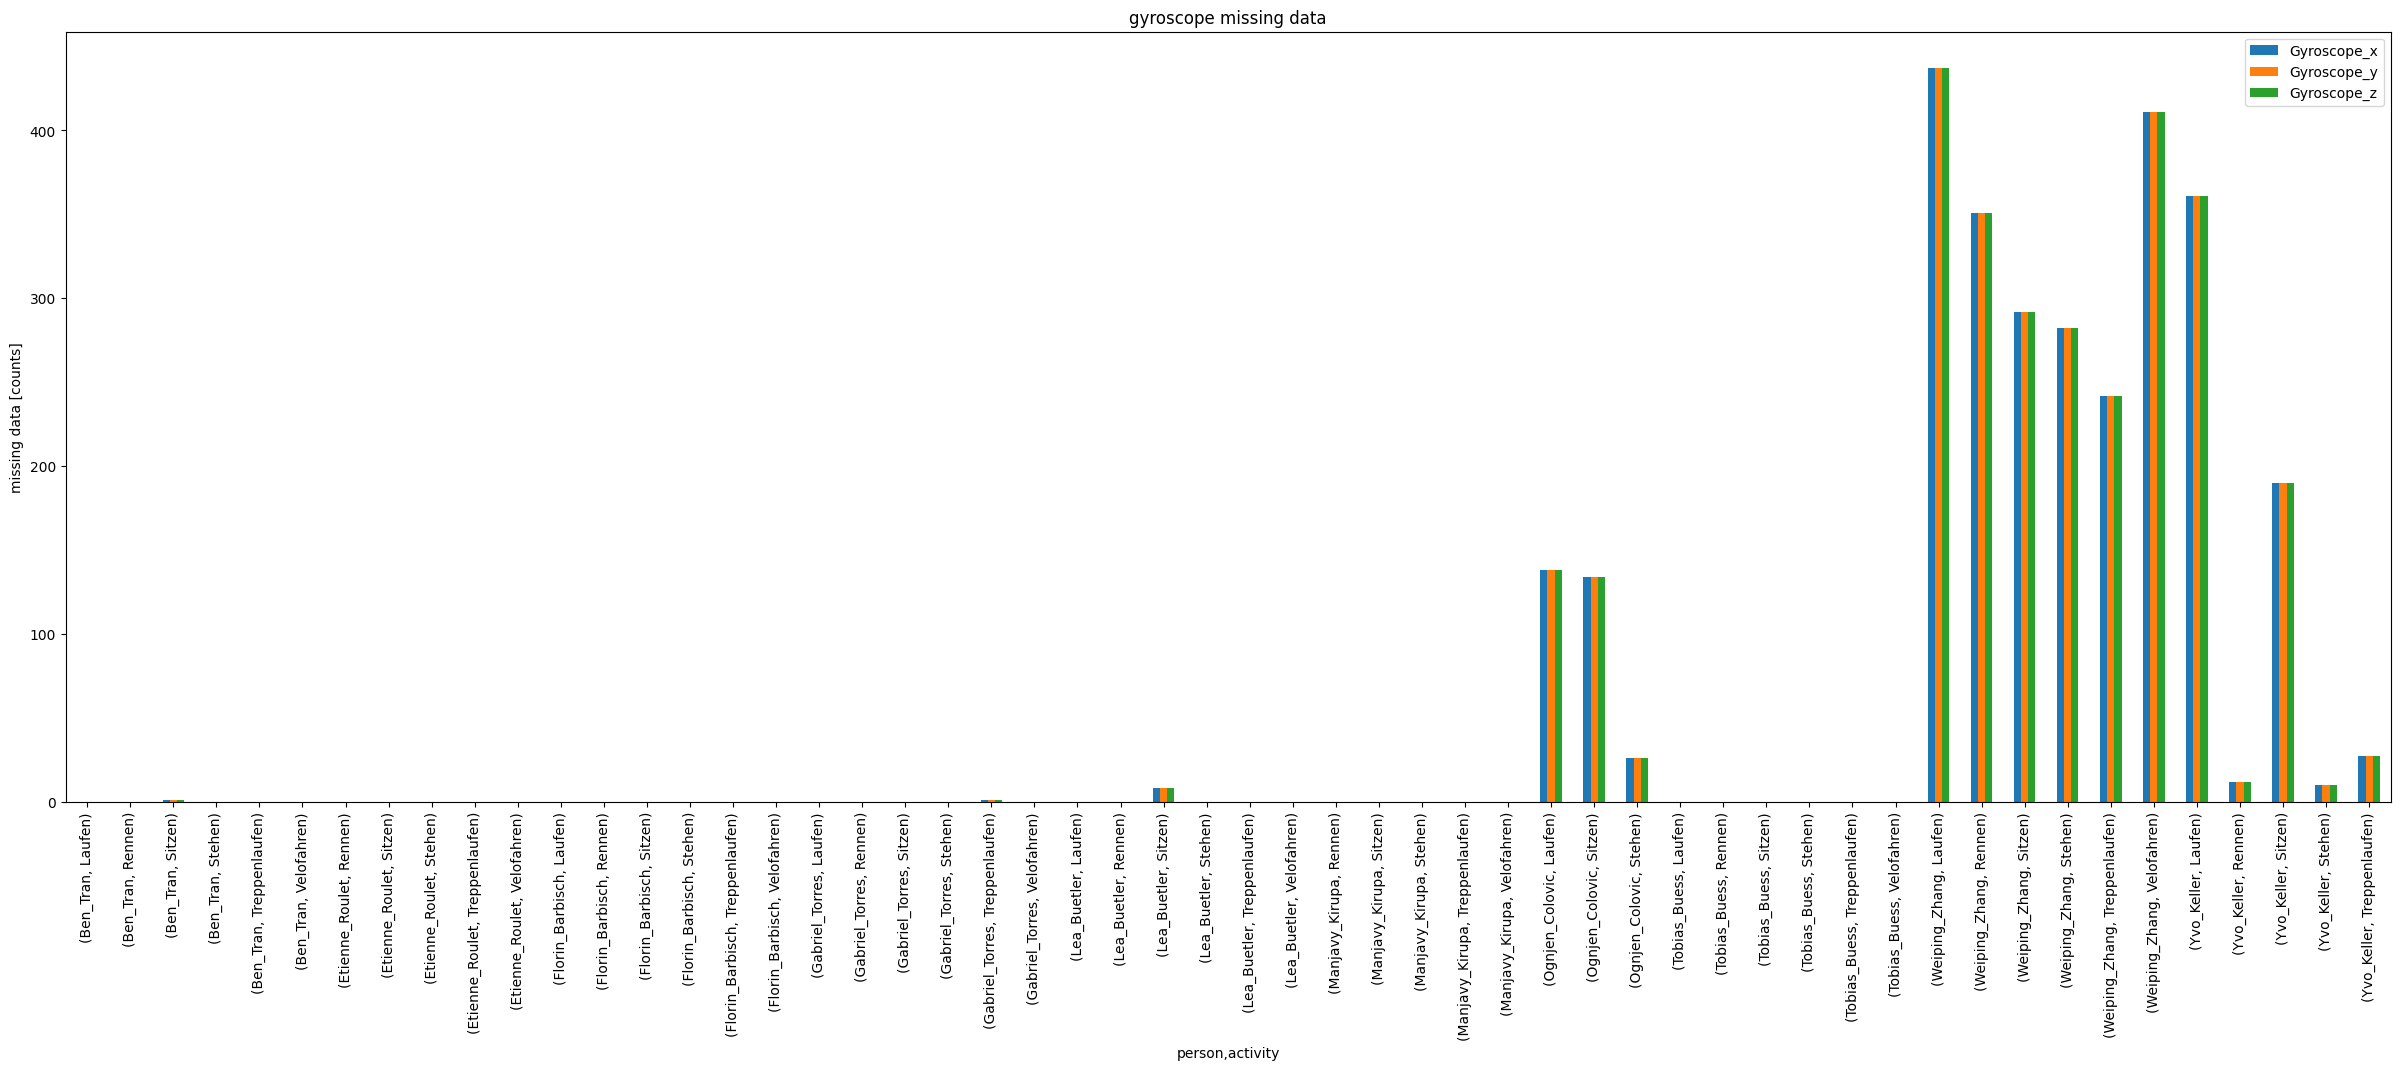

In [68]:
data[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]].isnull().groupby([data["person"], data["activity"]]).sum().plot.bar(figsize=(30,10))
plt.title("gyroscope missing data")
plt.ylabel("missing data [counts]")
plt.show()

In [73]:
#missing data in % as table
100*(data[["Gyroscope_x"]].isnull().groupby([data["person"], data["activity"]]).sum() / data[["Gyroscope_x"]].groupby([data["person"], data["activity"]]).count()).rename(columns={"Gyroscope_x": "missing data"})

missing data
person          activity                   
Ben_Tran        Laufen             0.000000
                Rennen             0.000000
                Sitzen             0.000514
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.000000
Etienne_Roulet  Rennen             0.000000
                Sitzen             0.000000
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.000000
Florin_Barbisch Laufen             0.000000
                Rennen             0.000000
                Sitzen             0.000000
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.000000
Gabriel_Torres  Laufen             0.000000
                Rennen             0.000000
                Sitzen             0.000000
                Stehen             0.000000
                Treppenlaufen      0.001294
                Velofahren         0.000000
Lea_Buetler     Laufen             0.000000
                Rennen             0.000000
                Sitzen             0.008519
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.000000
Manjavy_Kirupa  Rennen             0.000000
                Sitzen             0.000000
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.000000
Ognjen_Colovic  Laufen             0.097852
                Sitzen             0.110062
                Stehen             0.118419
Tobias_Buess    Laufen             0.000000
                Rennen             0.000000
                Sitzen             0.000000
                Stehen             0.000000
                Treppenlaufen      0.000000
                Velofahren         0.000000
Weiping_Zhang   Laufen             0.309424
                Rennen             0.308723
                Sitzen             0.324239
                Stehen             0.320965
                Treppenlaufen      0.315696
                Velofahren         0.307506
Yvo_Keller      Laufen             0.196179
                Rennen             0.185615
                Sitzen             0.200399
                Stehen             0.218436
                Treppenlaufen      0.187682

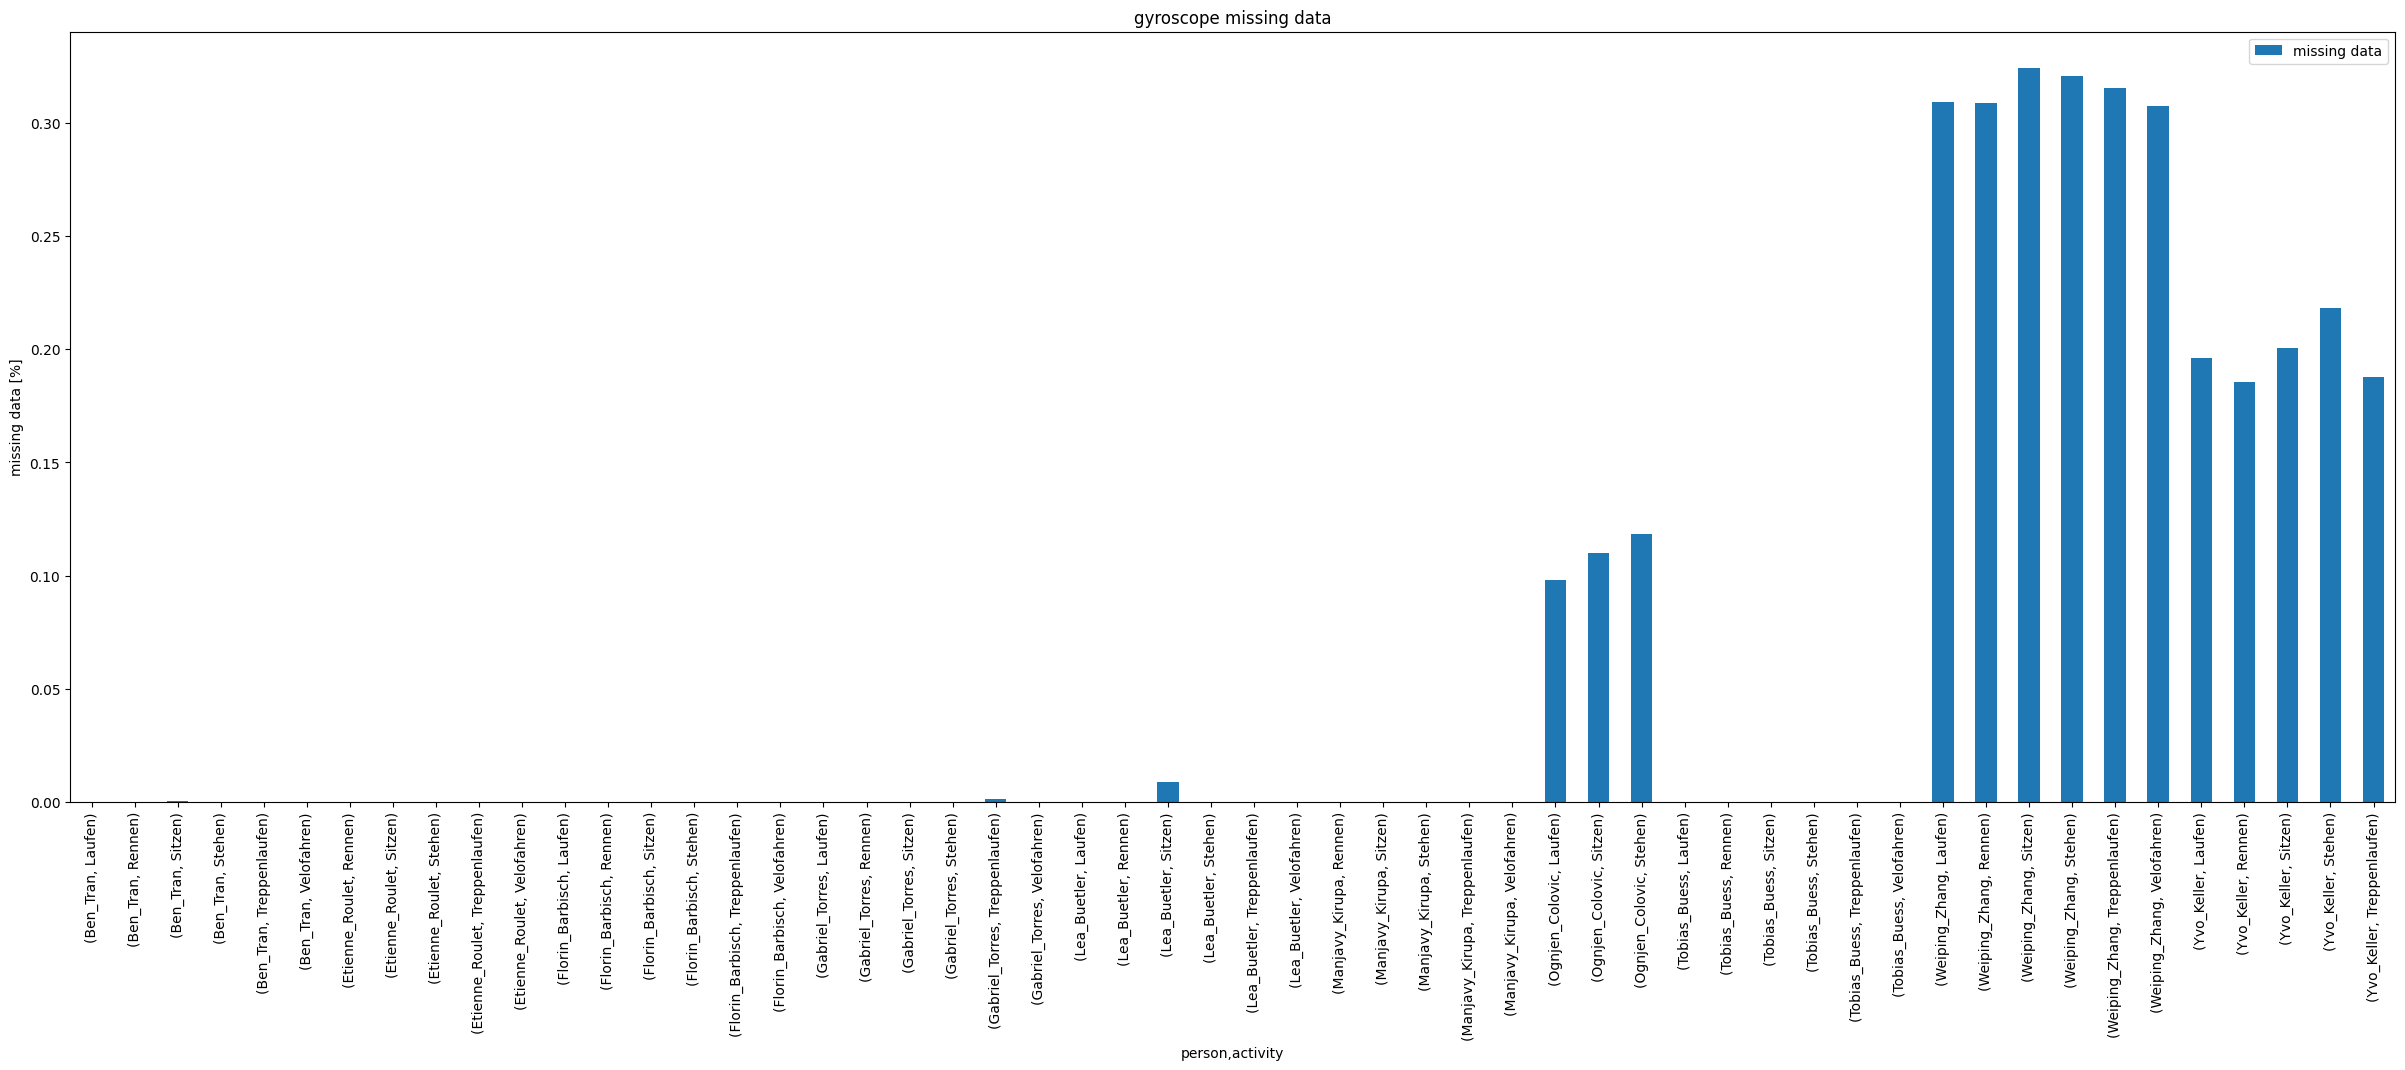

In [74]:
(100*(data[["Gyroscope_x"]].isnull().groupby([data["person"], data["activity"]]).sum() / data[["Gyroscope_x"]].groupby([data["person"], data["activity"]]).count())).rename(columns={"Gyroscope_x": "missing data"}).plot.bar(figsize=(30,10))
plt.title("gyroscope missing data")
plt.ylabel("missing data [%]")
plt.show()

# analyze raw data and test simple classification

C:\Users\tobia\AppData\Local\Temp\ipykernel_23080\2248247003.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for filename, df in get_person_activity("Ben_Tran", "Laufen").groupby(["filename"]):


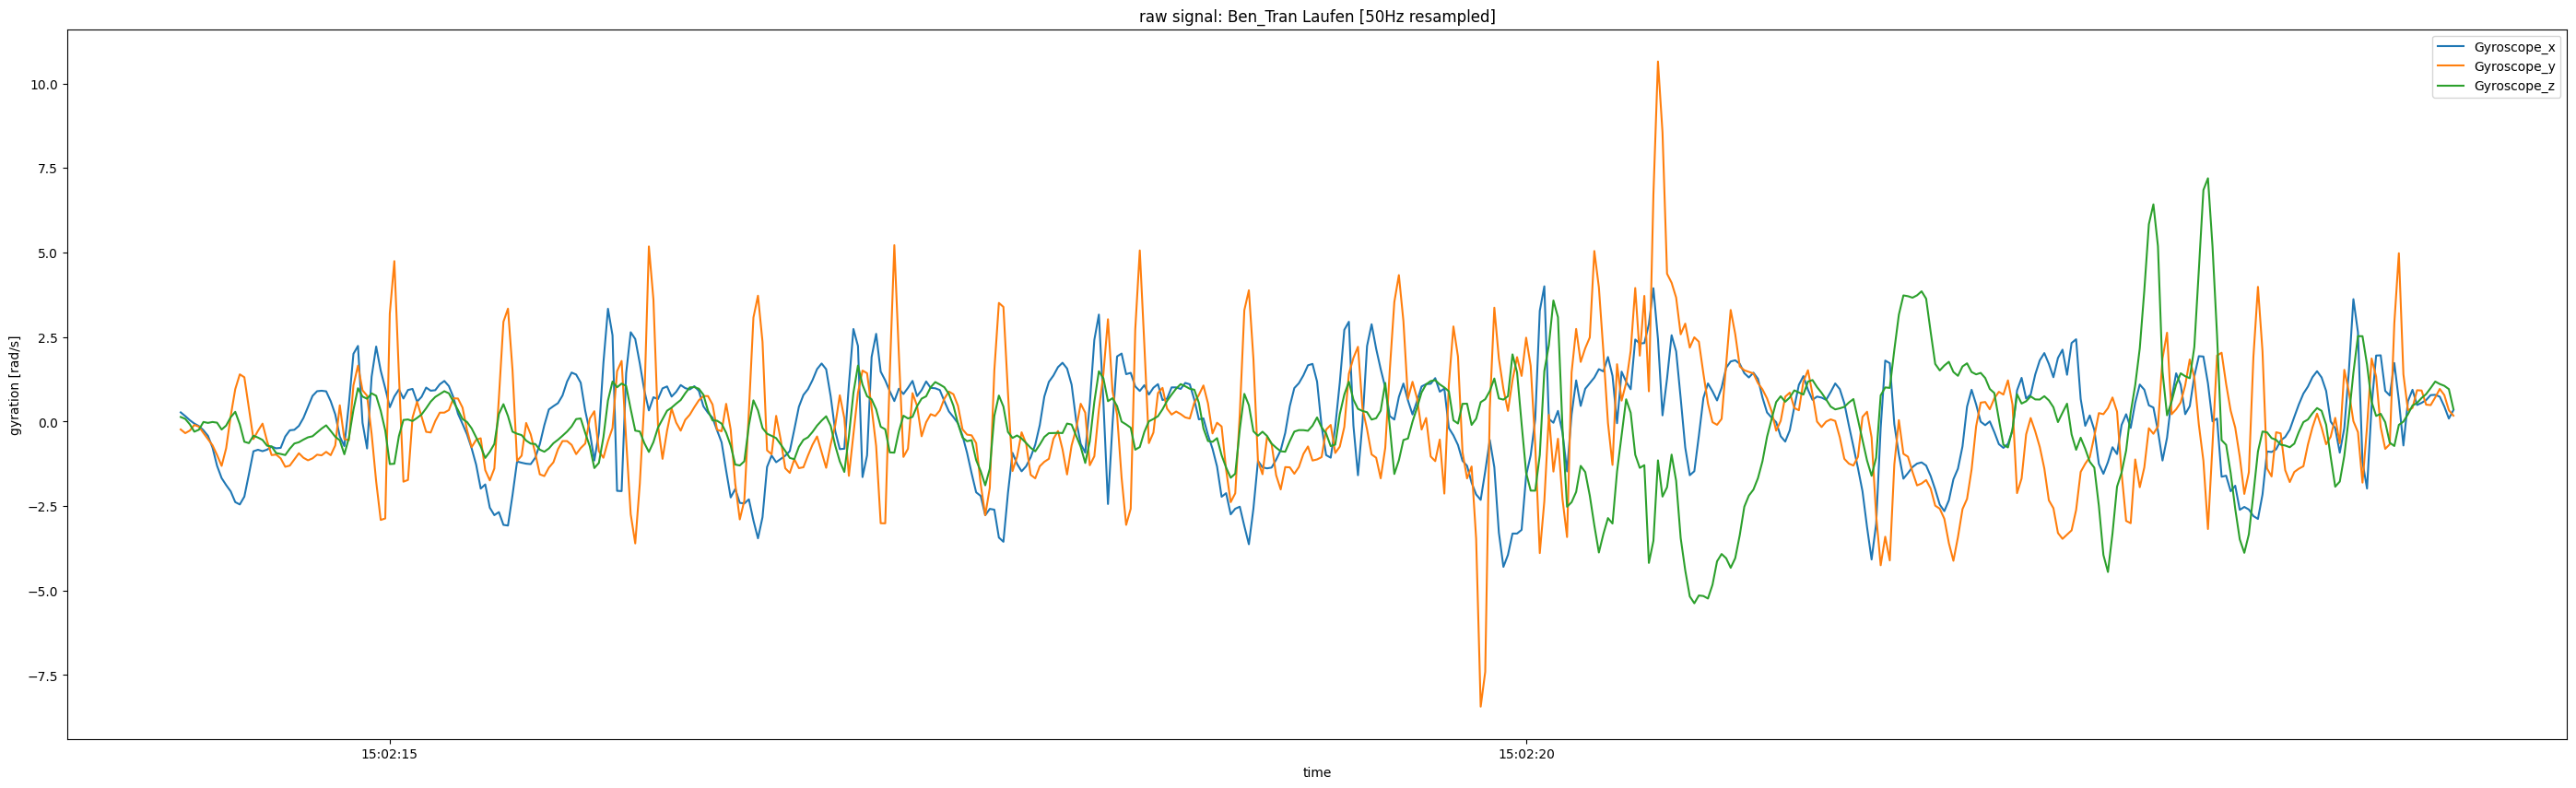

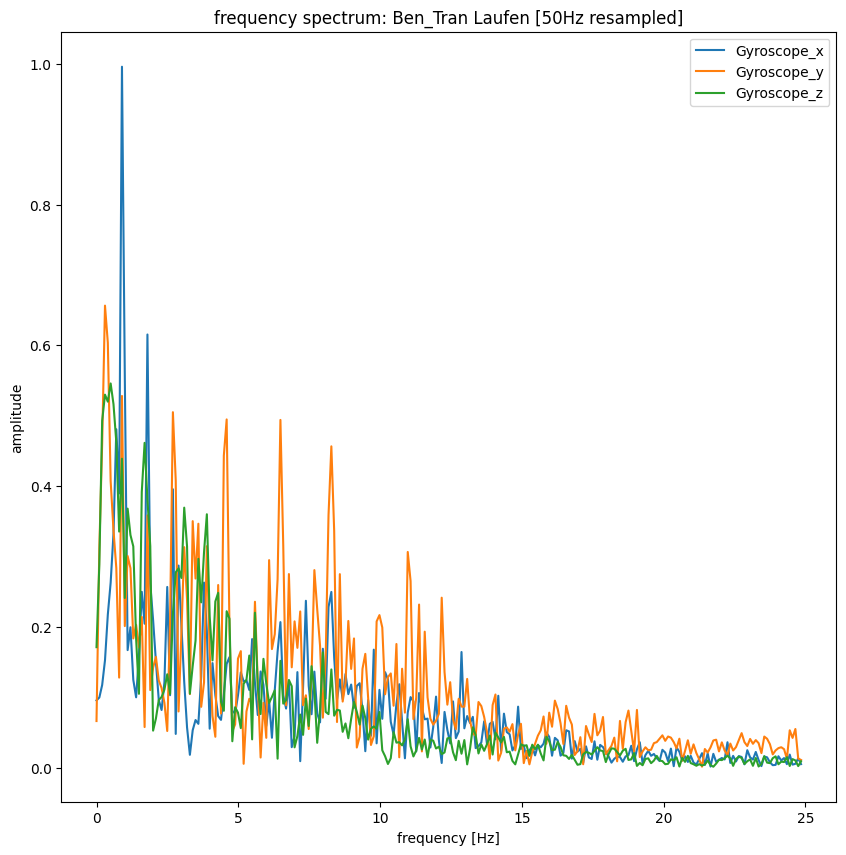

In [16]:
for filename, df in get_person_activity("Ben_Tran", "Laufen").groupby(["filename"]):
    plot_trunc_res_gyro(df, 10, 50)
    break

<ipython-input-5-a684bfbd02a6>:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for filename, df in get_person_activity("Florin_Barbisch", "Laufen").groupby(["filename"]):


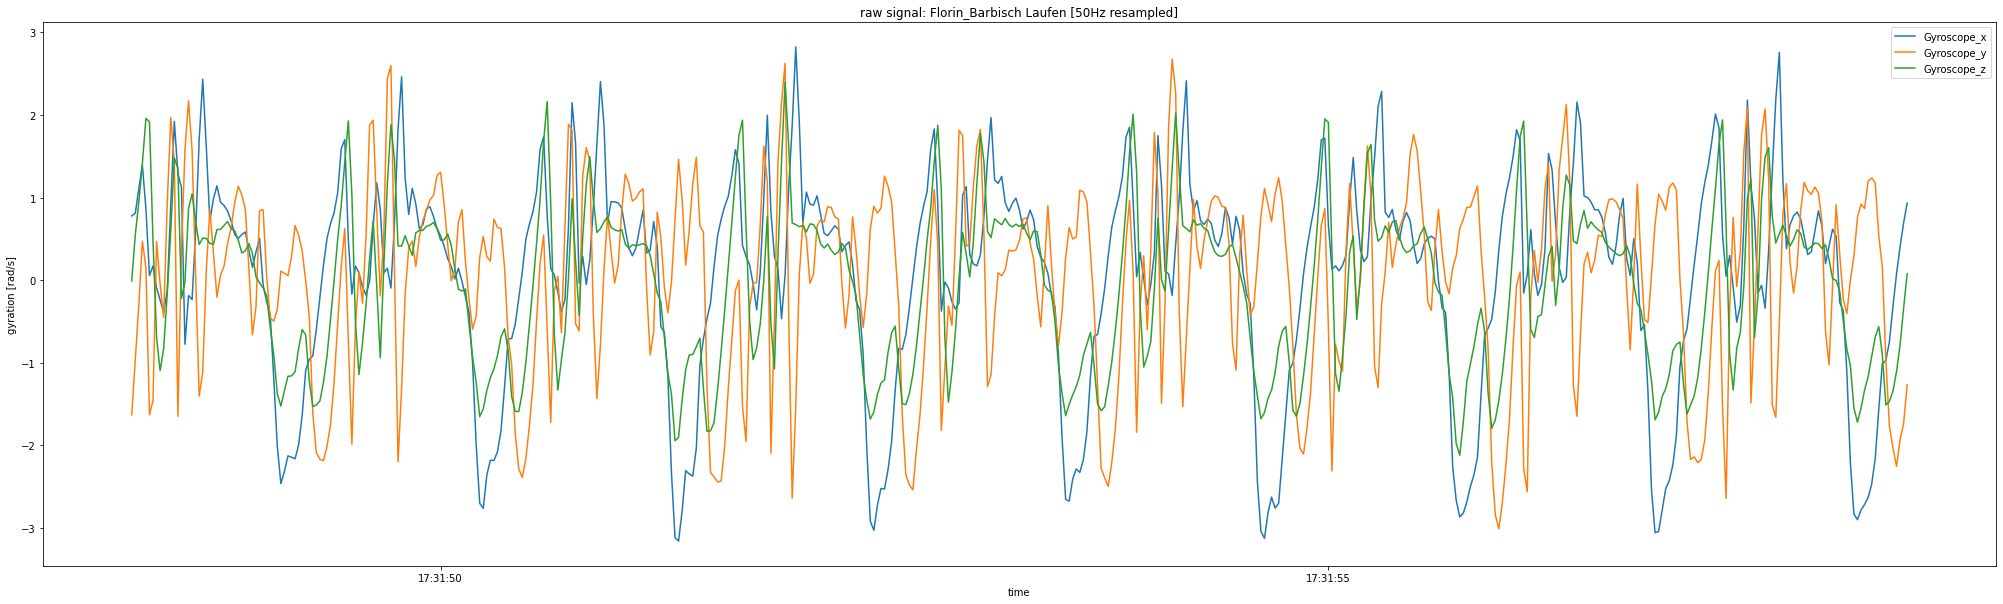

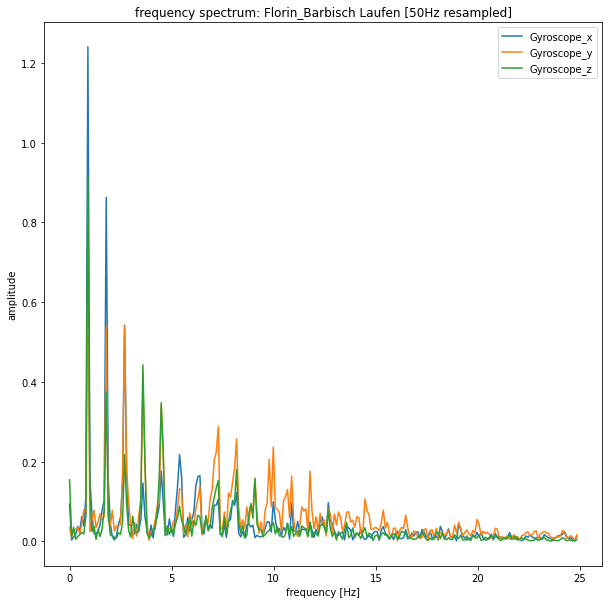

In [5]:
for filename, df in get_person_activity("Florin_Barbisch", "Laufen").groupby(["filename"]):
    plot_trunc_res_gyro(df, 10, 50)
    break

<ipython-input-22-14671d1d9c76>:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  _, df = get_person_activity("Ben_Tran", "Laufen").groupby(["filename"]).__iter__().__next__()


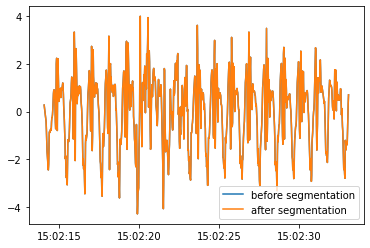

In [22]:
_, df = get_person_activity("Ben_Tran", "Laufen").groupby(["filename"]).__iter__().__next__()
df = resample_df(df[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]], 50)

df = pd.concat(segmentate(df.iloc[:1000], 1, 0))
plt.plot(df.index.values[:1000], df["Gyroscope_x"].values[:1000], label="before segmentation")
plt.plot(df.index.values[:1000], df["Gyroscope_x"].values[:1000], label="after segmentation")
plt.legend()
plt.show()

In [17]:
spectrums_laufen = []
for filename, df in get_activity("Laufen").groupby(["filename"]):
    segment_spectrums = np.array([list(get_fft_freqency_spectrum(segment).values())[1][1] for segment in segmentate(resample_df(df[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]], 50), 5, 0)]) #get frequency spectrum form x axis
    spectrums_laufen.append(segment_spectrums)

spectrums_laufen = np.vstack(spectrums_laufen)
laufen_class = np.full((len(spectrums_laufen),1), 0)

spectrums_laufen.shape

C:\Users\tobia\AppData\Local\Temp\ipykernel_23080\1508816464.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for filename, df in get_activity("Laufen").groupby(["filename"]):


(1620, 125)

In [18]:
spectrums_treppenlaufen = []
for filename, df in get_activity("Treppenlaufen").groupby(["filename"]):
    segment_spectrums = np.array([list(get_fft_freqency_spectrum(segment).values())[1][1] for segment in segmentate(resample_df(df[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]], 50), 5, 0)]) #get frequency spectrum form x axis
    spectrums_treppenlaufen.append(segment_spectrums)

spectrums_treppenlaufen = np.vstack(spectrums_treppenlaufen)
treppenlaufen_class = np.full((len(spectrums_treppenlaufen),1), 1)

spectrums_treppenlaufen.shape

C:\Users\tobia\AppData\Local\Temp\ipykernel_23080\1544869555.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for filename, df in get_activity("Treppenlaufen").groupby(["filename"]):


(955, 125)

In [23]:
spectrums_rennen = []
for filename, df in get_activity("Rennen").groupby(["filename"]):
    segment_spectrums = np.array([list(get_fft_freqency_spectrum(segment).values())[1][1] for segment in segmentate(resample_df(df[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]], 50), 5, 0)]) #get frequency spectrum form x axis
    spectrums_rennen.append(segment_spectrums)

spectrums_rennen = np.vstack(spectrums_rennen)
rennen_class = np.full((len(spectrums_rennen),1), 2)

spectrums_rennen.shape

C:\Users\tobia\AppData\Local\Temp\ipykernel_23080\3296754402.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for filename, df in get_activity("Rennen").groupby(["filename"]):


(1335, 125)

In [40]:
spectrums_stehen = []
for filename, df in get_activity("Stehen").groupby(["filename"]):
    segment_spectrums = np.array([list(get_fft_freqency_spectrum(segment).values())[1][1] for segment in segmentate(resample_df(df[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]], 50), 5, 0)]) #get frequency spectrum form x axis
    spectrums_stehen.append(segment_spectrums)

spectrums_stehen = np.vstack(spectrums_stehen)
stehen_class = np.full((len(spectrums_stehen),1), 3)

spectrums_stehen.shape

C:\Users\tobia\AppData\Local\Temp\ipykernel_23080\1885661193.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for filename, df in get_activity("Stehen").groupby(["filename"]):


(1113, 125)

In [48]:
spectrums_velo = []
for filename, df in get_activity("Velofahren").groupby(["filename"]):
    segment_spectrums = np.array([list(get_fft_freqency_spectrum(segment).values())[1][1] for segment in segmentate(resample_df(df[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]], 50), 5, 0)]) #get frequency spectrum form x axis
    spectrums_velo.append(segment_spectrums)

spectrums_velo = np.vstack(spectrums_velo)
velo_class = np.full((len(spectrums_velo),1), 4)

spectrums_velo.shape

C:\Users\tobia\AppData\Local\Temp\ipykernel_23080\2384460599.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for filename, df in get_activity("Velofahren").groupby(["filename"]):


(1533, 125)

In [52]:
spectrums_sitzen = []
for filename, df in get_activity("Sitzen").groupby(["filename"]):
    segment_spectrums = np.array([list(get_fft_freqency_spectrum(segment).values())[1][1] for segment in segmentate(resample_df(df[["Gyroscope_x", "Gyroscope_y", "Gyroscope_z"]], 50), 5, 0)]) #get frequency spectrum form x axis
    spectrums_sitzen.append(segment_spectrums)

spectrums_sitzen = np.vstack(spectrums_sitzen)
sitzen_class = np.full((len(spectrums_sitzen),1), 5)

spectrums_sitzen.shape

C:\Users\tobia\AppData\Local\Temp\ipykernel_23080\530291530.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for filename, df in get_activity("Sitzen").groupby(["filename"]):


(1945, 125)

In [53]:
X = np.vstack((spectrums_laufen, spectrums_treppenlaufen, spectrums_rennen, spectrums_stehen, spectrums_velo, spectrums_sitzen))
Y = np.vstack((laufen_class, treppenlaufen_class, rennen_class, stehen_class, velo_class, sitzen_class))

p = np.random.permutation(len(X))
X = X[p]
Y = Y[p]

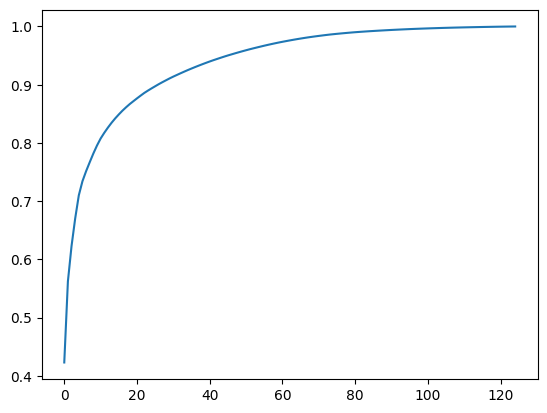

n_components:  45


In [54]:
pca = PCA().fit(X)

n = np.argwhere(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

print("n_components: ", n)

X_ = PCA(n_components=n).fit_transform(X)

6800
1701
train score:  1.0
test score:  0.8918283362727807


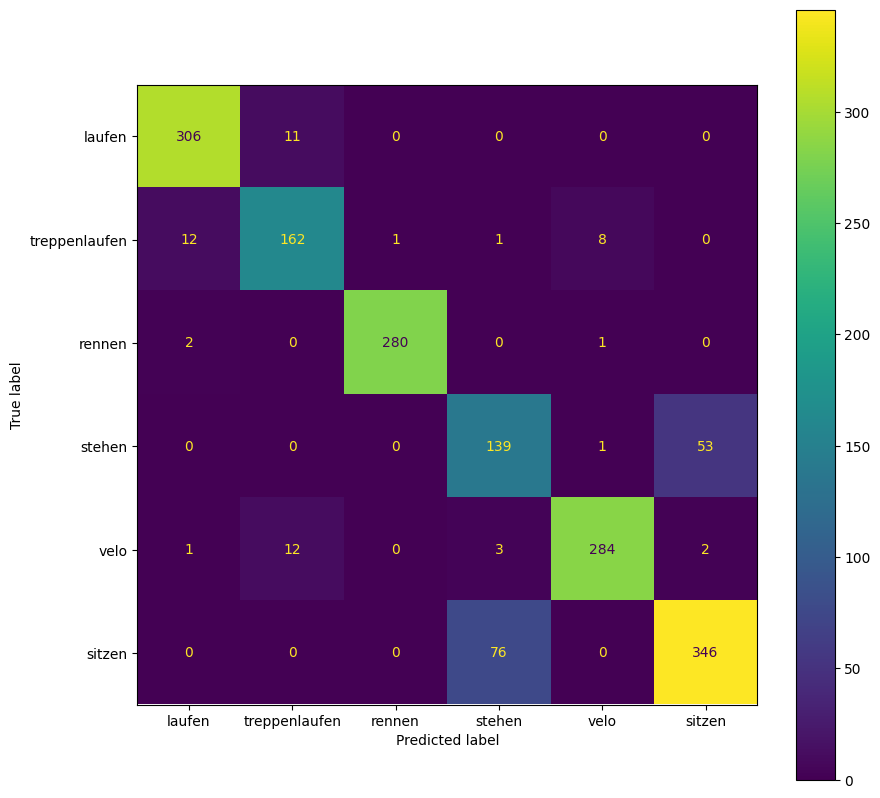

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(X_, Y, train_size=0.8)

print(len(X_train))
print(len(X_test))

hgbc:HistGradientBoostingClassifier = HistGradientBoostingClassifier().fit(X_train, Y_train.flatten())

print("train score: ", hgbc.score(X_train, Y_train.flatten()))
print("test score: ", hgbc.score(X_test, Y_test.flatten()))

cm = confusion_matrix(hgbc.predict(X_test), Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["laufen", "treppenlaufen", "rennen", "stehen", "velo", "sitzen"])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()